#  importing used libraries

In [373]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
from scipy.stats import norm

# importing records

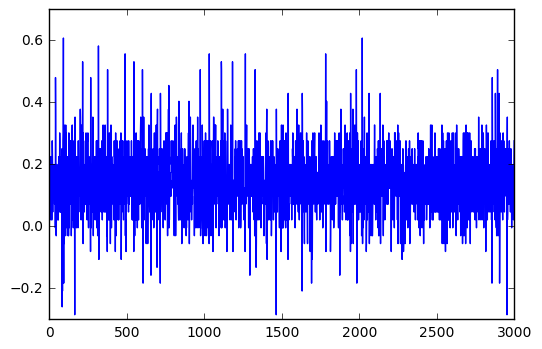

In [374]:
Raw_Lateral = scipy.io.loadmat('lateral.mat') #import mat data as dictionary
Raw_Palmar = scipy.io.loadmat('palmar.mat')

Raw_Palmar=(Raw_Palmar['palmar']) #save data as 2D array 
Raw_Lateral=(Raw_Lateral['lateral'])

plt.plot(Raw_Lateral[80]) #Ploting record 80 as an example
plt.show()

# Electric noise cancelation filter

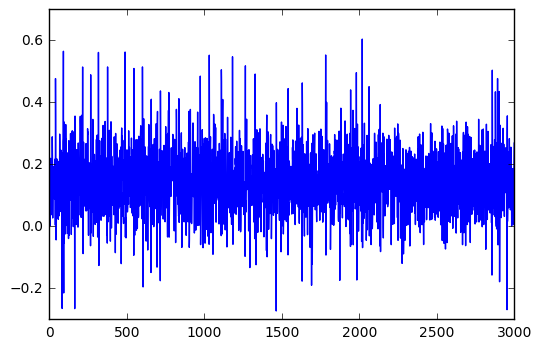

In [375]:
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):#This filter function is taken as it is from
    from scipy.signal import iirfilter,lfilter  #http://stackoverflow.com/questions/35565540/designing-an-fir-notch-filter-with-python

    fs   = 1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data

Raw_Palmar=Implement_Notch_Filter(1/1000,4,50,100,3,'bessel',Raw_Palmar)#store the filtered row_palmar into row_palmar
Raw_Lateral=Implement_Notch_Filter(1/1000,4,50,100,3,'bessel',Raw_Lateral)#store the filtered row_lateral into row_lateral

plt.plot(Raw_Lateral[80])#Ploting record 80 as an example
plt.show()

# Converting the raw table into features table

In [376]:
def features_tabel (table): #Function to calculate features

    Energy=np.sum(table**2,axis = 1)#Calculate energy
    Power =np.sum(table**4,axis = 1) #Calculate power


    NLPower = np.zeros(table.shape[0])# array of zeros that will hold the value of non linear Power for each record
    CLenght = np.zeros(table.shape[0])# array of zeros that will hold the value of curve lenght for each record

    i=0         #Pointer that will move along rows
    n=0         #Pointer taht will move along columns

    while (i <table.shape[0]): #Loop that will sum the values along rows to a one single row
    
        while (n<table.shape[1]):#Loop that will sum the values along columns to two values per row(non linear power and curve lenght)
        
            if (n>1):
                NLPower[i]=NLPower[i]+((-table[i][n]*table[i][n-2])+(table[i][n-1]**2))#Nonlinear power
            
            if (n>0):
                CLenght[i]=CLenght[i]+(table[i][n]-table[i][n-1])#Curve length
            n=n+1
        i=i+1
        n=0
    return np.vstack((Energy,Power,NLPower,CLenght)).T

In [377]:
Palmar=features_tabel(Raw_Palmar) #creating the features table of the palmar records
print(Palmar[0:3])#Printing the first three palmar records as an example

Lateral=features_tabel(Raw_Lateral) #creating the features table of the Lateral records
print(Lateral[0:3])#Printing the first three Lateral records as an example

[[  2.09109882e+02   4.80911181e+01   1.71126132e+02  -3.52600609e-01]
 [  2.22067831e+02   5.87228240e+01   1.94949787e+02  -2.56870830e-01]
 [  2.13983737e+02   4.90919886e+01   1.85715908e+02  -1.96479695e-02]]
[[  1.91669786e+02   4.38642899e+01   1.54279132e+02   6.90795637e-01]
 [  1.86337446e+02   4.16352726e+01   1.47882192e+02   3.59288787e-01]
 [  1.84113595e+02   3.86918778e+01   1.51220804e+02  -4.72513901e-02]]


# Shuffling records

In [378]:
np.random.shuffle(Lateral) #Shuffling plamer and lateral rows
np.random.shuffle(Palmar)

# Slicing tables into training tables and testing tables

In [379]:
Training=int ( (Palmar.shape[0]*5)/7) #Number of training records
Testing =Palmar.shape[0]-Training #Number of testing records

P_Training = Palmar[0:Training,:]  #Palmar training table
P_Testing = Palmar[Training:,:]     #Palmar testing table

L_Training = Lateral[0:Training,:]#Lateral testing table
L_Testing = Lateral[Training:,:]  #Lateral training table

print (Training,Testing)

107 43


# Mean calculation

In [380]:

temp=np.mean(L_Training,axis=0) #store the mean of the lateral table columns(features) into a temp storage

ML_E=temp[0]#Mean Lateral energy
ML_P=temp[1]#Mean Lateral power
ML_NLE=temp[2]#Mean non linear energy
ML_CL=temp[3]#Mean Lateral curve lenght

print(ML_CL) #print mean lateral curve lenght as an example


temp=np.mean(P_Training,axis=0) #store the mean of the Palmar table columns(features) into a temp storage
MP_E=temp[0]#Mean Lateral energy
MP_P=temp[1]#Mean Palmar power
MP_NLE=temp[2]#Mean non linear energy
MP_CL=temp[3]#Mean Palmar curve length

print(MP_CL)#print mean Palmar curve lenght as an example


0.00520521455785
-0.0140262886887


# Standared deviation calculation

In [381]:
temp=np.std(L_Training, axis=0)#get the standard deviation of each column 
print(temp)

SDL_E = temp[0] #store the standard deviation value of lateral energy
SDL_P = temp[1]
SDL_NLE = temp[2]
SDL_CL = temp[3]

temp=np.std(P_Training, axis=0)
print(temp)

SDP_E = temp[0]
SDP_P = temp[1]
SDP_NLE = temp[2]
SDP_CL = temp[3]

[  97.81485005  164.39456457  133.83055267    0.20376394]
[  3.88824124e+02   1.48600326e+03   4.75393858e+02   3.06757903e-01]


# Probability calculation

In [382]:
def Probability(array,row,column, mean, stdev):  #function to calculate probability from mean and std deviation 
                                                 #for 1 element
    dist=norm(mean,stdev)
    return dist.pdf(array[row][column]) #Returns the probability of a given element to lie in the given distribution

In [383]:
def Record_Probability(array,r,EM,ESTD,PM,PSTD,NLM,NLSTD,CLM,CLSTD):#function to calculate the probability of the whole record to lie 
                                                             #in the given ranges, it calls the function "Probability" for each record
    temp=Probability(array,r,0,EM,ESTD)*Probability(array,r,1,PM,PSTD)*Probability(array,r,2,NLM,NLSTD)*Probability(array,r,3,CLM,CLSTD)
    return temp 
    

# Accuracy calculation

In [384]:
#loop to select all test records (palmar and lateral) one by one and calculate to probailities for each
#Propability of this record to be palmer, and for it to be lateal
#If the higher probability is the correct one, n (varialble) will be increased by one
#Number of correct records is then divided by the total number of test values to get accurecy

r=0 #pointer moves amoung records
n=0 #holds the number of the correct records
while r<Testing:
    l=Record_Probability(L_Testing,r,ML_E,SDL_E,ML_P,SDL_P,ML_NLE,SDL_NLE,ML_CL,SDL_CL)#the probability of lateral record to be lateral
    p=Record_Probability(L_Testing,r,MP_E,SDP_E,MP_P,SDP_P,MP_NLE,SDP_NLE,MP_CL,SDP_CL)#the probability of Palmar record to be lateral
    if l>p:
        n=n+1 #In is increased if the probability of lateral record to be lateral is greater than of it to be palmar
    pp=Record_Probability(P_Testing,r,MP_E,SDP_E,MP_P,SDP_P,MP_NLE,SDP_NLE,MP_CL,SDP_CL) #the probability of Palamr record to be Palamr   
    ll=Record_Probability(P_Testing,r,ML_E,SDL_E,ML_P,SDL_P,ML_NLE,SDL_NLE,ML_CL,SDL_CL)#the probability of palmar record to be lateral
    if pp>ll:
        n=n+1
    r=r+1
Acc=n/(Testing*2)
print(Acc*100)

70.93023255813954
